In [56]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [57]:
# ---------------------------------
# Task 0: Computing the Mean and Std Dev
# ---------------------------------

# Load training data without normalization
raw_dataset = torchvision.datasets.MNIST(
    root='./data', train=True, download=True,
    transform=transforms.ToTensor()
)

raw_loader = DataLoader(raw_dataset, batch_size=1000, shuffle=False)

# Compute mean and std
mean = 0.
std = 0.
n = 0

for images, _ in raw_loader:
    batch_samples = images.size(0)
    images = images.view(batch_samples, -1)
    mean += images.mean(1).sum()
    std += images.std(1).sum()
    n += batch_samples

mean /= n
std /= n

print(f"Computed Mean: {mean.item():.4f}")
print(f"Computed Std: {std.item():.4f}")


Computed Mean: 0.1307
Computed Std: 0.3015


In [58]:
# -------------------------------
# Task 1: Data Preparation
# -------------------------------

# Explanation:
# We normalize the MNIST dataset using mean = 0.1307 and std = 0.3081 (computed from the training set).
# This helps with faster and more stable training convergence.
# Data augmentation (rotation, translation) helps prevent overfitting by making the model generalize better.

In [59]:
transform_train = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3015,))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3015,))
])

In [60]:
# Loading MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform_test)

In [61]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

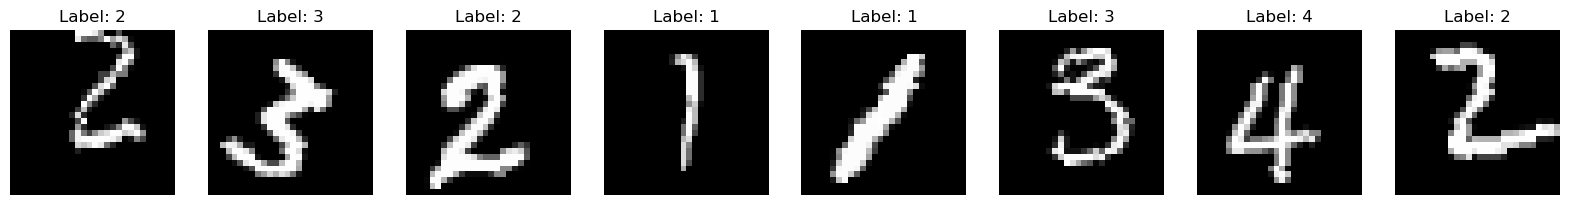

In [62]:

# Visualize a batch to confirm wheather the data loading and augmentation is correctly done or not.
def visualize_batch():
    images, labels = next(iter(train_loader))
    fig, axes = plt.subplots(1, 8, figsize=(20, 2.5))
    for i in range(8):
        axes[i].imshow(images[i].squeeze(), cmap='gray')
        axes[i].set_title(f'Label: {labels[i].item()}')
        axes[i].axis('off')
    plt.show()

visualize_batch()

In [63]:
# -------------------------------
# Task 2: CNN Architecture Design
# -------------------------------

# CNN Explanation:
# - Two convolutional layers (ReLU activation and max pooling).
# - Final layer outputs 10 logits (for digits 0 to 9).

In [64]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        
    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        x = torch.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 32 * 7 * 7)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return torch.log_softmax(x, dim=1)
    
model = CNN()
criterion = nn.CrossEntropyLoss()  
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [65]:
loss_values = []

def train_model(num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        avg_loss = running_loss / len(train_loader)
        loss_values.append(avg_loss)
        print(f'Epoch {epoch+1}, Loss: {avg_loss:.4f}')

    # Save training loss plot
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, num_epochs + 1), loss_values, marker='o', color='blue')
    plt.title("Training Loss over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("training_loss_plot.png")
    plt.show()


In [66]:
def evaluate_model():
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.numpy())
            all_labels.extend(labels.numpy())
    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')
    return all_preds, all_labels



Epoch 1, Loss: 0.3018
Epoch 2, Loss: 0.1009
Epoch 3, Loss: 0.0744
Epoch 4, Loss: 0.0625
Epoch 5, Loss: 0.0557
Epoch 6, Loss: 0.0497
Epoch 7, Loss: 0.0462
Epoch 8, Loss: 0.0433
Epoch 9, Loss: 0.0401
Epoch 10, Loss: 0.0384


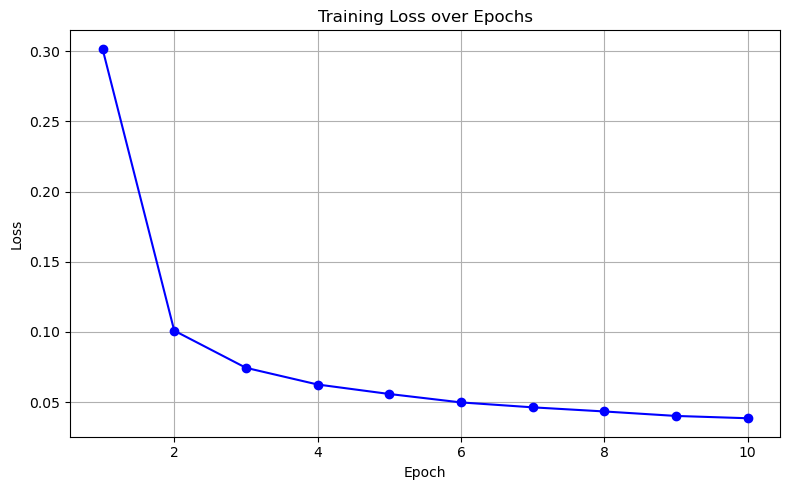

Test Accuracy: 99.36%


In [67]:
# Training and evaluating the model
# Training the model by using the 10 epochs.
train_model(num_epochs=10)
all_preds, all_labels = evaluate_model()

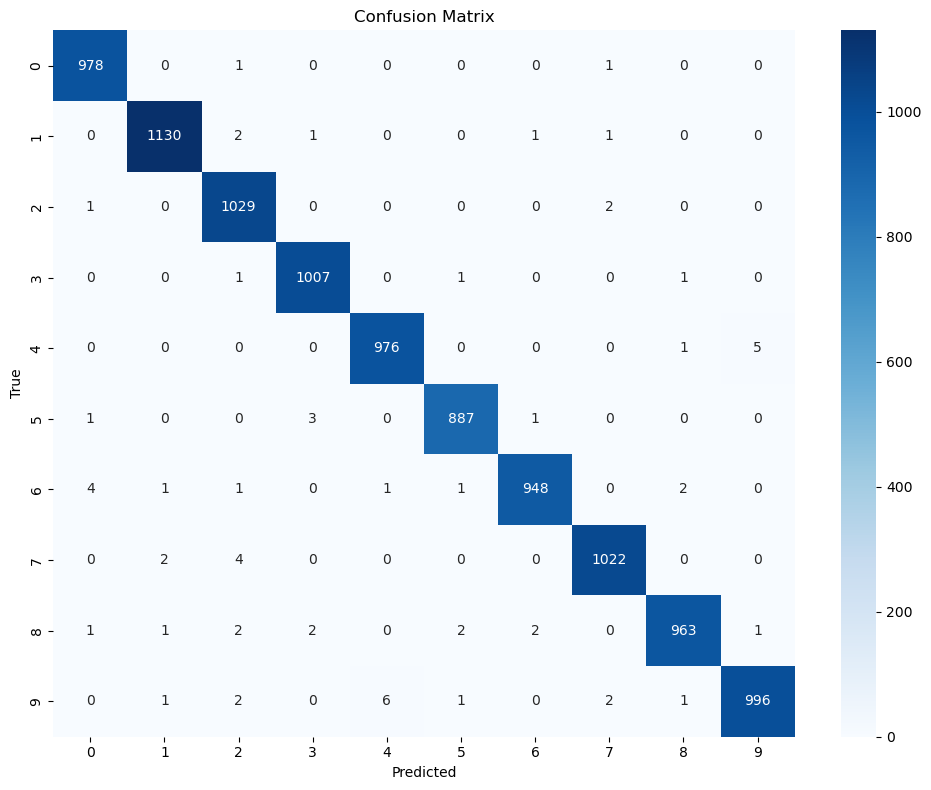

In [68]:
# As we can see from the above output run the loss function gradually decreases for the number of epochs so the loss is very less
# -------------------------------
# Task 4: Analyzing the model using the Confusion matrix 
# -------------------------------
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig("confusion_matrix.png")
plt.show()

In [69]:
# Confusion matrix Analysis:

# From the above confusion matrix the Digit 1 has the highest number of correct predictions which is (1130).
# Digit 5 has relatively lower accuracy compared to other digits.

In [70]:
# Accuracy:
# The model has achieved a test accuracy of around 99.36%, which is very good for MNIST using a simple CNN.


In [71]:
# Performance Analysis:

# - The confusion matrix shows some confusion between visually similar digits (e.g., 4 and 9).
# - The training loss has decreased gradually, indicating effective learning of the model.


In [72]:
# Challenges:
# - Initially tuning the CNN architecture was tricky. Small kernel sizes and stride/padding choices affect performance.
# - Data augmentation values needed fine-tuning — too much shift or rotation degrades accuracy.

# Improvements:
# 1. Addition of Dropout layers can reduce the overfitting further.
# 2. Training of more epochs (10–20) or apply learning rate can increase the model accuracy better.
